Prepare state space trajectories for a lexical analysis.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
import itertools
from pathlib import Path
import pickle
from typing import Any

import datasets
import matplotlib.pyplot as plt
from mne.decoding import ReceptiveField
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
import torch
import transformers
from tqdm.auto import tqdm, trange

from src.analysis.trf import estimate_trf_cv
from src.models import get_best_checkpoint
from src.models.integrator import ContrastiveEmbeddingModel, load_or_compute_embeddings

In [6]:
model_dir = "outputs/models/w2v2_6_8/phoneme"
# model_checkpoint = "out/ce_model_phoneme_6_8/checkpoint-800"
# use a word-level equivalence dataset regardless of model, so that we can look up cohort facts
equiv_dataset_path = "data/timit_equivalence_facebook-wav2vec2-base_6-phoneme-1.pkl"
timit_corpus_path = "data/timit_syllables"

strffeat_path = "/userdata/jgauthier/ilina_timit/speech_analysis/out_sentence_details_timit_all_loudness.mat"
strffeat_extract_features = ["aud",
                            #  "F0",  # TODO copy over pitch analysis code
                             "maxDtL",
                             "phnfeatConsOnset",
                             "formantMedOnset"]

output_dir = "."

In [7]:
model = ContrastiveEmbeddingModel.from_pretrained(get_best_checkpoint(model_dir))
model.eval()

/home/jgauthier/u/transformers/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


ContrastiveEmbeddingModel(
  (rnn): RNNModel(
    (rnn): LSTM(768, 32, batch_first=True)
    (fc): Linear(in_features=32, out_features=8, bias=True)
  )
)

In [8]:
with open(equiv_dataset_path, "rb") as f:
    equiv_dataset = pickle.load(f)

In [9]:
frames_by_item = equiv_dataset.hidden_state_dataset.frames_by_item

In [10]:
model_representations = load_or_compute_embeddings(model, equiv_dataset, model_dir, equiv_dataset_path)

In [12]:
pca = PCA(2).fit(model_representations)
model_representations_pca = pca.transform(model_representations)

In [13]:
timit_corpus = datasets.load_from_disk(timit_corpus_path)["train"]

In [37]:
all_phonemes = set(equiv_dataset.class_labels)

In [45]:
cmudict_features = {
    "AA": "low back",
    "AE": "low front",
    "AH": "low",
    "AO": "low back",
    "AW": "back rounded",
    "AY": "high front",
    "B": "bilabial plosive",
    "CH": "voiceless palato-alveolar affricate",
    "D": "alveolar plosive",
    "DH": "dental fricative",
    "EH": "front",
    "ER": "",
    "EY": "front rounded",
    "F": "voiceless labiodental fricative",
    "G": "velar plosive",
    "HH": "voiceless glottal fricative",
    "IH": "high front",
    "IY": "high front rounded",
    "JH": "palato-alveolar affricate",
    "K": "voiceless velar plosive",
    "L": "alveolar lateral approximant",
    "M": "bilabial nasal",
    "N": "alveolar nasal",
    "NG": "velar nasal",
    "OW": "back rounded",
    "OY": "back rounded",
    "P": "voiceless bilabial plosive",
    "R": "alveolar approximant",
    "S": "voiceless alveolar fricative",
    "SH": "voiceless palato-alveolar fricative",
    "T": "voiceless alveolar plosive",
    "TH": "voiceless dental fricative",
    "UH": "high back rounded",
    "UW": "high back rounded",
    "V": "labiodental fricative",
    "W": "labio-velar approximant",
    "Y": "palatal approximant",
    "Z": "alveolar fricative",
    "ZH": "palato-alveolar fricative",
}
cmudict_features = {k: v.split() for k, v in cmudict_features.items()}

# NB there is no "voiced" feature -- this is to avoid overcomplete representation / singular
# matrix issues
# NB vowel height has no "mid" feature -- avoid overcompleteness
# NB vowel height has no "central" feature -- avoid overcompleteness
# NB vowels have no "unrounded" feature -- avoid overcompleteness

In [46]:
all_features = list(sorted(set(itertools.chain(*cmudict_features.values()))))
phon_feature2idx = {f: i for i, f in enumerate(all_features)}

In [47]:
# Prepare categorization of these features for a feature selection analysis
feature_categories = {
    "consonant_place": "alveolar bilabial dental glottal labio-velar labiodental palatal palato-alveolar velar".split(),
    "consonant_manner": "affricate approximant fricative lateral nasal plosive".split(),
    "vowel": "back front low high rounded".split(),
    "voicing": "voiceless".split(),
}

for c1, c2 in itertools.combinations(feature_categories, 2):
    assert not set(feature_categories[c1]) & set(feature_categories[c2])
assert set(itertools.chain.from_iterable(feature_categories.values())) == set(all_features), \
    f"Missing features: {set(all_features) - set(itertools.chain.from_iterable(feature_categories.values()))}"

In [48]:
cmudict_feature_idxs = {k: [phon_feature2idx[f] for f in v] for k, v in cmudict_features.items()}

In [49]:
phon_feature_to_phonemes = {f: [k for k, v in cmudict_features.items() if f in v] for f in all_features}

In [50]:
assert all(type(label) == str for label in equiv_dataset.class_labels), "Assumes dataset with phoneme labels"

## Prepare TIMIT features from STRF encoder

In [ ]:
# from scipy.io import loadmat

# strffeat = loadmat(strffeat_path, simplify_cells=True)["sentdet"]
# strffeat_all_names = [x["name"] for x in strffeat]

# # Prepare relevant feature shortnames
# for trial in strffeat:
#     trial["onset"] = trial["onsOff"][0]
#     trial["offset"] = trial["onsOff"][1]

#     trial["phnfeatConsOnset"] = trial["phnfeatonset"][[0, 1, 2, 7, 8, 10]]
    
#     trial["maxDtL"] = trial["loudnessall"][5]

#     # auditory and spectral features
#     trial["aud"] = trial["aud"][:80]
#     # trial["F0"] = trial["f0"][0]
#     trial["formantMedOnset"] = trial["frmMedOns"][:4]

In [ ]:
# name_to_item_idx, name_to_frame_bounds, compression_ratios = {}, {}, {}
# def process_item(item, idx):
#     name = Path(item["file"]).parent.stem.lower() + "_" + item["id"].lower()
#     if name in strffeat_all_names:
#         name_to_item_idx[name] = idx

#         frame_start, frame_end = equiv_dataset.hidden_state_dataset.frames_by_item[idx]
#         name_to_frame_bounds[name] = (frame_start, frame_end)
#         compression_ratios[name] = (frame_end - frame_start) / len(item["input_values"])
# timit_corpus.map(process_item, with_indices=True)

# item_idx_to_name = {v: k for k, v in name_to_item_idx.items()}

In [ ]:
# # Make sure that sentence features and model embeddings are of approximately the same length,
# # modulo sampling differences. Compute length of each sentence in seconds according
# # to two sources:
# comparisons = [(strffeat_i["aud"].shape[1] / 100 - 1, # remove padding
#                 (name_to_frame_bounds[strffeat_i['name']][1] - name_to_frame_bounds[strffeat_i['name']][0]) / compression_ratios[strffeat_i["name"]] / 16000)
#                 for strffeat_i in strffeat if strffeat_i["name"] in name_to_frame_bounds]
# np.testing.assert_allclose(*zip(*comparisons), atol=0.04,
#                             err_msg="ECoG data and model embeddings should be of approximately the same length")

In [ ]:
# # Pre-compute the total number of features
# strffeat_feature_names = []
# for feature_set in strffeat_extract_features:
#     feature_example = strffeat[0][feature_set]
#     if feature_example.ndim == 2:
#         strffeat_feature_names.extend([f"{feature_set}_{i}" for i in range(feature_example.shape[0])])
#     else:
#         strffeat_feature_names.append(feature_set)

# strffeat_feature_dim = len(strffeat_feature_names)

In [ ]:
# from scipy.signal import resample

# strffeat_feature_matrices: dict[int, np.ndarray] = {}
# for trial_i in tqdm(strffeat):
#     name = trial["name"]
#     if name not in name_to_item_idx:
#         continue

#     frame_start, frame_end = name_to_frame_bounds[name]
#     ret_features_i = np.zeros((strffeat_feature_dim, frame_end - frame_start))

#     feature_offset = 0
#     for feature_set in strffeat_extract_features:
#         feature_ij = trial[feature_set]
#         if feature_ij.ndim == 1:
#             feature_ij = feature_ij[None, :]
#         # feature_ij : (n_features, n_samples)

#         # Trim padding
#         before_pad, after_pad = trial["befaft"]
#         before_pad = int(trial["dataf"] * before_pad)
#         after_pad = int(trial["dataf"] * after_pad)
#         feature_ij = feature_ij[:, before_pad:-after_pad]

#         # Resample to match the model's sampling rate
#         # If this is an onset feature, do this manually by visiting each nonzero
#         # value and finding the corresponding frame
#         is_onset_feature = set(itertools.chain.from_iterable(feature_ij.tolist())) == {0, 1}
#         if is_onset_feature:
#             for feature_idx, sample in zip(*feature_ij.nonzero()):
#                 # convert to model sample index
#                 sample = int(sample / trial["dataf"] * 16000 * compression_ratios[name])
#                 ret_features_i[feature_offset + feature_idx, sample] = 1.
#         else:
#             for feature_idx in range(feature_ij.shape[0]):
#                 ret_features_i[feature_offset + feature_idx] = \
#                     resample(feature_ij[feature_idx], frame_end - frame_start)

#         feature_offset += feature_ij.shape[0]

#     strffeat_feature_matrices[name_to_item_idx[name]] = ret_features_i

In [ ]:
# name_to_item_idx["mzmb0_si1796"]
# np.array(timit_corpus[1133]["phonemic_detail"]["start"]) / 16000

## Prepare design matrix

In [51]:
feature_names = ["onset_item", "onset_word", "onset_phoneme"]

use_strffeat_features = False
if use_strffeat_features:
    feature_names += strffeat_feature_names
else:
    feature_names += list(phon_feature_to_phonemes.keys())

feature2idx = {name: i for i, name in enumerate(feature_names)}
design_matrix = np.zeros((model_representations.shape[0], len(feature_names)))
fit_mask = np.ones(model_representations.shape[0], dtype=bool)

def update_design_matrix(item, idx):
    start_frame, end_frame = frames_by_item[idx]
    num_frames = end_frame - start_frame
    compression_ratio = num_frames / len(item["input_values"])

    design_matrix[start_frame, feature2idx["onset_item"]] = 1.

    if use_strffeat_features and idx not in strffeat_feature_matrices:
        fit_mask[start_frame:end_frame] = False
        return

    for word in item["word_phonemic_detail"]:
        if len(word) == 0:
            continue

        word_start = start_frame + int(word[0]["start"] * compression_ratio)
        design_matrix[word_start, feature2idx["onset_word"]] = 1.

        for phoneme in word:
            phoneme_start = start_frame + int(phoneme["start"] * compression_ratio)
            design_matrix[phoneme_start, feature2idx["onset_phoneme"]] = 1.

            if not use_strffeat_features:
                for feature in cmudict_features[phoneme["phone"]]:
                    design_matrix[phoneme_start, feature2idx[feature]] = 1.

    if use_strffeat_features:
        for strffeat_feature_idx, feature_name in enumerate(strffeat_feature_names):
            design_matrix[start_frame:end_frame, feature2idx[feature_name]] = \
                strffeat_feature_matrices[idx][strffeat_feature_idx]

timit_corpus.map(update_design_matrix, with_indices=True)

Map:   0%|          | 0/4620 [00:00<?, ? examples/s]

Dataset({
    features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id', 'word_phonetic_detail', 'input_values', 'phone_targets', 'phonemic_detail', 'word_phonemic_detail', 'word_syllable_detail'],
    num_rows: 4620
})

In [52]:
# Estimate feature correlation in design matrix
feature_correlation = np.corrcoef(design_matrix[fit_mask].T)
feature_correlation[np.diag_indices_from(feature_correlation)] = 0
pd.DataFrame(feature_correlation, index=feature_names, columns=feature_names) \
    .reset_index().melt(id_vars=["index"]).sort_values("value")

,index,variable,value
244,alveolar,front,-0.059597
106,front,alveolar,-0.059597
292,alveolar,high,-0.052145
108,high,alveolar,-0.052145
562,front,voiceless,-0.051524
...,...,...,...
572,plosive,voiceless,0.614102
459,affricate,palato-alveolar,0.676715
91,palato-alveolar,affricate,0.676715
252,high,front,0.775069


## Basic model fit

In [54]:
trf = estimate_trf_cv(
    design_matrix,
    model_representations,
    [str(idx) for idx in range(model_representations.shape[1])],
    feature_names=feature_names, tmin=-1, tmax=5, sfreq=1,
    n_splits=3,
    return_predictions=True)

Fitting 1 epochs, 24 channels


  0%|          | Sample : 0/324 [00:00<?,       ?it/s]

Fitting 1 epochs, 24 channels


  0%|          | Sample : 0/324 [00:00<?,       ?it/s]

Fitting 1 epochs, 24 channels


  0%|          | Sample : 0/324 [00:00<?,       ?it/s]

In [55]:
trf.scores

,0,1,2,3,4,5,6,7
fold,,,,,,,,
0,0.616739,0.618093,0.619105,0.617096,0.617798,0.453401,0.613206,0.614714
1,0.610172,0.611545,0.612154,0.610540,0.611243,0.443227,0.606733,0.607627
2,0.615430,0.617164,0.617920,0.615980,0.616595,0.449324,0.612435,0.613167


In [56]:
trf.coefs.to_csv(Path(output_dir) / "trf_df.csv")
trf.scores.to_csv(Path(output_dir) / "trf_scores.csv")

In [57]:
largest_coefs = trf.coefs.groupby(["feature"]).apply(lambda xs: xs.groupby("output_name").coef.apply(np.linalg.norm).agg(["idxmax", "max"])).sort_values("max").iloc[-30:]
largest_coefs

coef,idxmax,max
feature,,
lateral,2,0.237588
low,3,0.277740
rounded,3,0.302020
onset_word,3,0.315749
onset_item,3,0.453564
voiceless,3,0.540170
front,3,0.605590
nasal,3,0.653862
fricative,3,0.730813


In [58]:
highlight_df = pd.merge(trf.coefs, largest_coefs.reset_index(),
                        left_on=["feature", "output_name"], right_on=["feature", "idxmax"])

In [59]:
# baseline by pre-onset activation
highlight_df = pd.merge(highlight_df, highlight_df.groupby(["feature", "output_name", "fold"]).apply(lambda xs: xs[xs.lag <= 0].coef.mean()).rename("baseline"),
                        left_on=["feature", "output_name", "fold"], right_index=True)
highlight_df["coef_baselined"] = highlight_df["coef"] - highlight_df["baseline"]
highlight_df["feature"] = highlight_df.feature.astype(str)

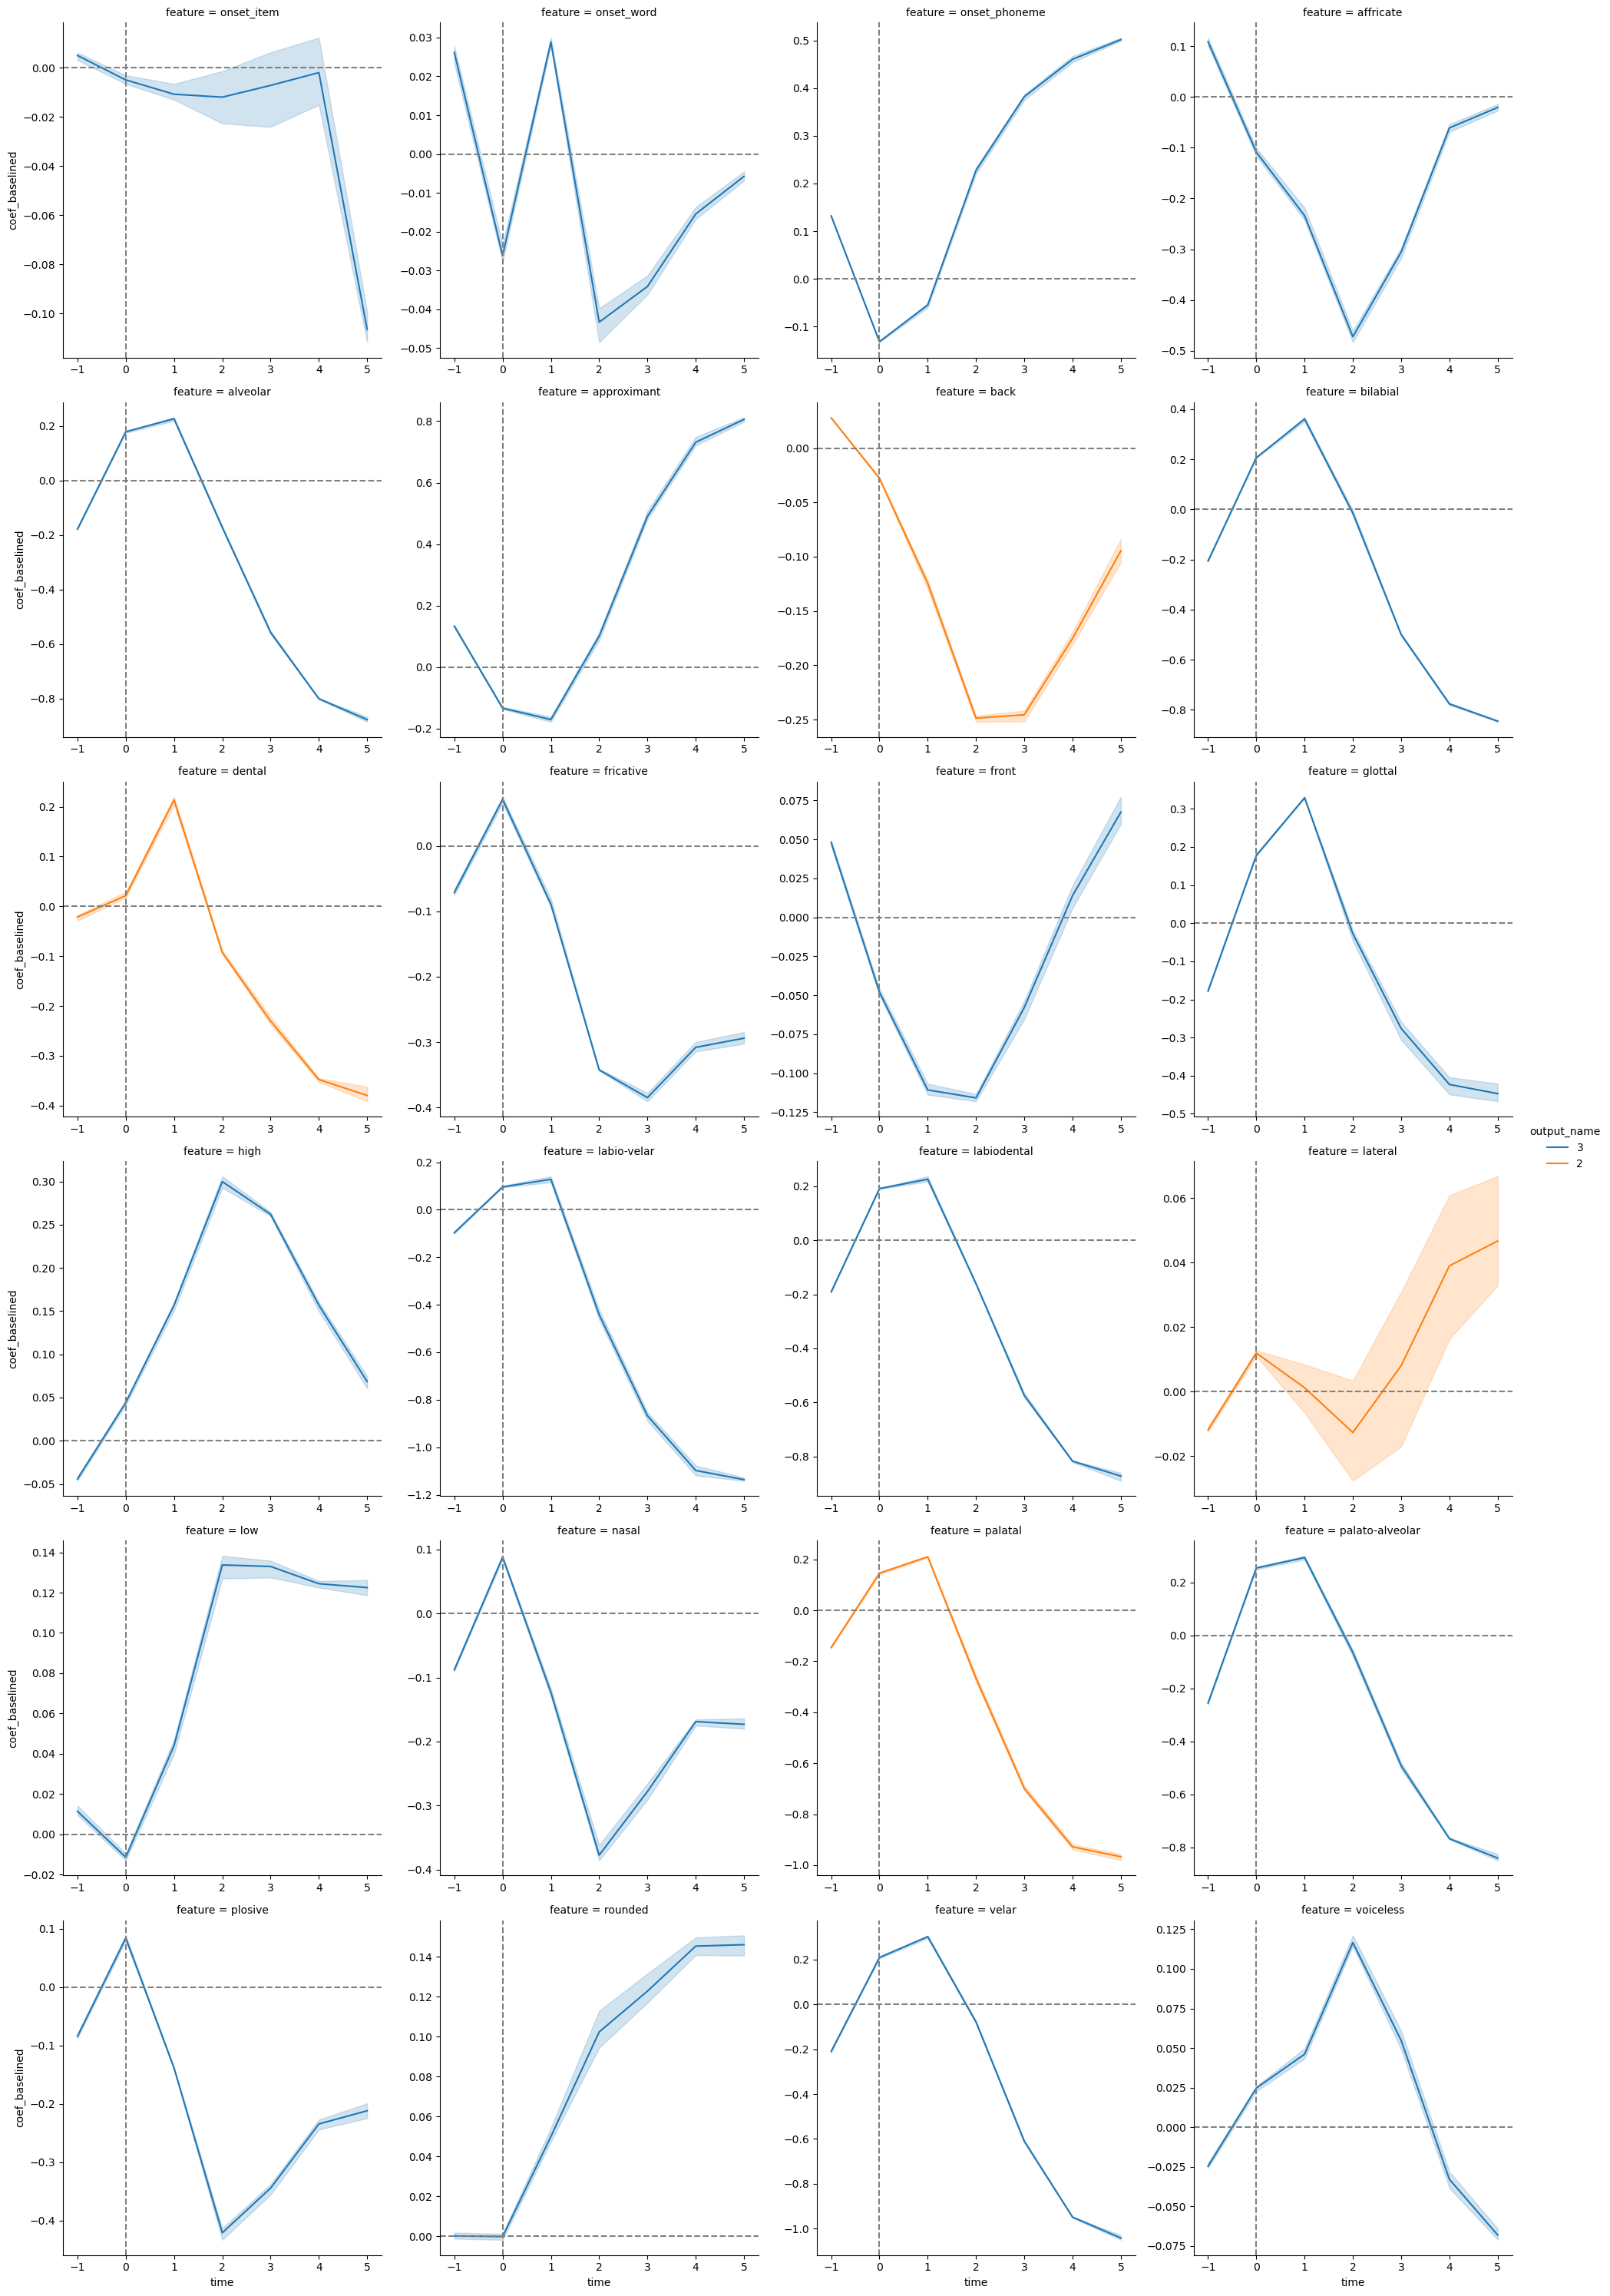

In [60]:
g = sns.relplot(data=highlight_df, col="feature", col_wrap=4,
                x="time", y="coef_baselined", hue="output_name", kind="line",
                facet_kws=dict(sharex=False, sharey=False))

for ax in g.axes.flat:
    ax.axhline(0, color="gray", linestyle="--")
    ax.axvline(0, color="gray", linestyle="--")

In [ ]:
smallest_coefs = trf.coefs.groupby(["feature"]).apply(lambda xs: xs.groupby("output_name").coef.apply(np.linalg.norm).agg(["idxmin", "min"])).sort_values("min").iloc[:30]
highlight_df = pd.merge(trf.coefs, smallest_coefs.reset_index(),
                        left_on=["feature", "output_name"], right_on=["feature", "idxmin"])
# baseline by pre-onset activation
highlight_df = pd.merge(highlight_df, highlight_df.groupby(["feature", "output_name", "fold"]).apply(lambda xs: xs[xs.lag <= 0].coef.mean()).rename("baseline"),
                        left_on=["feature", "output_name", "fold"], right_index=True)
highlight_df["coef_baselined"] = highlight_df["coef"] - highlight_df["baseline"]
highlight_df["feature"] = highlight_df.feature.astype(str)

g = sns.relplot(data=highlight_df, col="feature", col_wrap=4,
                x="time", y="coef_baselined", hue="output_name", kind="line",
                facet_kws=dict(sharex=False, sharey=False))

for ax in g.axes.flat:
    ax.axhline(0, color="gray", linestyle="--")
    ax.axvline(0, color="gray", linestyle="--")

### Plot predictions

In [71]:
def plot_item(item_idx, ax):
    item = timit_corpus[item_idx]
    start_frame, end_frame = frames_by_item[item_idx]
    compression_ratio = (end_frame - start_frame) / len(item["input_values"])

    times = np.linspace(0, len(item["input_values"]) / 16000, int(len(item["input_values"]) / 16000 * 1000))
    ax.plot(times, np.interp(times, np.arange(len(item["input_values"])) / 16000,
                            item["input_values"]),
            alpha=0.3)

    # plot word and phoneme boundaries
    for i, word in enumerate(item["word_phonemic_detail"]):
        word_str = item["word_detail"]["utterance"][i]

        word_start, word_stop = word[0]["start"] / 16000, word[-1]["stop"] / 16000
        ax.axvline(word_start, color="black", linestyle="--")
        ax.text(word_start, -6, word_str, rotation=90, verticalalignment="top")

        for j, phoneme in enumerate(word):
            phoneme_str = phoneme["phone"]
            phoneme_start, phoneme_stop = phoneme["start"] / 16000, phoneme["stop"] / 16000

            if j > 0:
                color = "black" if phoneme["idx_in_syllable"] == 0 else "gray"
                ax.axvline(phoneme_start, color=color, linestyle=":")
            ax.text(phoneme_start + 0.01, -5, phoneme_str, rotation=90, verticalalignment="bottom", fontdict={"size": 8})

    model_ax = ax.twinx()
    palette = sns.color_palette("tab10", model_representations.shape[1])
    for dim in range(model_representations.shape[1]):
        model_ax.plot(times, np.interp(times, np.arange(0, end_frame - start_frame) / compression_ratio / 16000,
                                model_representations[start_frame:end_frame, dim]),
                      label=f"dim{dim}", color=palette[dim])

    # align at origin
    ax.set_ylim((-8, 8))
    model_ax.set_ylim((-2, 2))
    model_ax.legend()

    ax.set_title(f"{item['speaker_id']}_{item['id']}: {item['text']}")

    return ax, model_ax

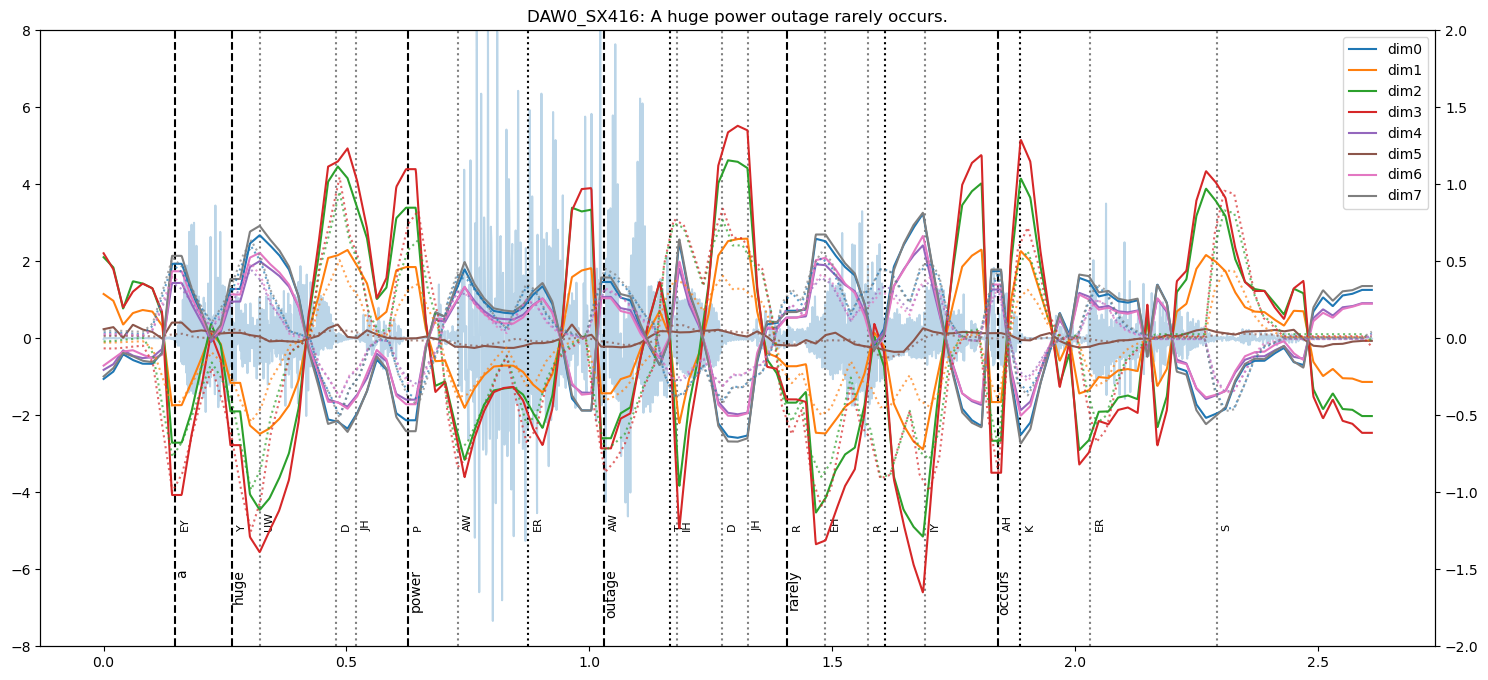

In [73]:
plot_item_idx = 18
start_frame, end_frame = frames_by_item[plot_item_idx]
compression_ratio = (end_frame - start_frame) / len(timit_corpus[plot_item_idx]["input_values"])

f, ax = plt.subplots(figsize=(18, 8))
ax, twinx = plot_item(plot_item_idx, ax)

# plot predicted time course
predicted = trf.predictions[start_frame:end_frame]
times = np.linspace(0, len(timit_corpus[plot_item_idx]["input_values"]) / 16000, predicted.shape[0])
palette = sns.color_palette("tab10", predicted.shape[1])
for dim in range(predicted.shape[1]):
    twinx.plot(times, predicted[:, dim], label=f"dim{dim}", linestyle=":", alpha=0.7, color=palette[dim])

## Feature category forward selection

In [74]:
feature_category_list = list(feature_categories.keys())
n_categories_to_select = len(feature_category_list) - 1

def get_design_matrix_mask(feature_category_mask):
    mask = np.ones(len(feature_names), dtype=bool)

    assert len(feature_category_list) == len(feature_category_mask)
    for category, include in zip(feature_category_list, feature_category_mask):
        for feature in feature_categories[category]:
            mask[feature2idx[feature]] = include
    return mask


def estimate_model_with_selection(feature_category_mask):
    mask = get_design_matrix_mask(feature_category_mask)
    feature_names_masked = [name for name, mask_i in zip(feature_names, mask) if mask_i]
    trf = estimate_trf_cv(
        design_matrix[:, mask],
        model_representations,
        [str(idx) for idx in range(model_representations.shape[1])],
        feature_names=feature_names_masked, tmin=-1, tmax=5, sfreq=1,
        n_splits=3)
    return trf

In [75]:
import mne
mne.set_log_level("ERROR")

In [80]:
best_mask = np.zeros(len(feature_category_list), dtype=bool)
best_trf = estimate_model_with_selection(best_mask)
category_trajectory = [None]
score_trajectory = [best_trf.scores.mean().mean()]

for _ in trange(n_categories_to_select):
    candidate_category_idxs = np.flatnonzero(~best_mask)
    candidate_models = []

    for i, category_idx in enumerate(tqdm(candidate_category_idxs)):
        candidate_mask = best_mask.copy()
        candidate_mask[category_idx] = True
        candidate_model = estimate_model_with_selection(candidate_mask)
        candidate_models.append(candidate_model)

        print(f"New score with {feature_category_list[category_idx]}: {candidate_model.scores.mean().mean()}")

    candidate_score_means = np.array([model.scores.mean().mean() for model in candidate_models])
    best_candidate_score = candidate_score_means.max()
    if best_candidate_score > best_trf.scores.mean().mean():
        best_candidate_idx = candidate_score_means.argmax()
        print(f"Best improvement with {feature_category_list[candidate_category_idxs[best_candidate_idx]]}: {best_candidate_score}")

        best_new_category_idx = candidate_category_idxs[best_candidate_idx]
        best_mask[best_new_category_idx] = True
        best_trf = candidate_models[best_candidate_idx]

        category_trajectory.append(feature_category_list[best_new_category_idx])
        score_trajectory.append(best_candidate_score)

    print(f"=== Best category set: {', '.join(feature_category_list[idx] for idx in best_mask.nonzero()[0])}; {best_trf.scores.mean().mean()} ===")

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

New score with consonant_place: -1016.2966914082938
New score with consonant_manner: 0.05030157211901036
New score with vowel: -0.010054570403529486
New score with voicing: -0.05958489664499354
Best improvement with consonant_manner: 0.05030157211901036
1
=== Best category set: consonant_manner; 0.05030157211901036 ===


  0%|          | 0/3 [00:00<?, ?it/s]

New score with consonant_place: -0.05792503171066793
New score with vowel: -0.24427961335179632
New score with voicing: -0.02039359827051275
=== Best category set: consonant_manner; 0.05030157211901036 ===


  0%|          | 0/3 [00:00<?, ?it/s]

New score with consonant_place: -0.05792503171066793
New score with vowel: -0.24427961335179632
New score with voicing: -0.02039359827051275
=== Best category set: consonant_manner; 0.05030157211901036 ===


In [ ]:
selection_traj = pd.DataFrame({"category": category_trajectory, "score": score_trajectory})
selection_traj.to_csv(Path(output_dir) / "trf_feature_selection_trajectory.csv")
selection_traj